<a href="https://colab.research.google.com/github/CShorten/Robust-Vector-Search/blob/main/CLIP_Classifier_and_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install clip-server > /dev/null
!pip install clip-client > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
arviz 0.11.4 requires typing-extensions<4,>=3.7.4.3, but you have typing-extensions 4.1.1 which is incompatible.


In [ ]:
!unzip cifar10_clip_embeds.zip

In [9]:
from clip_client import Client

c = Client("grpc://demo-cas.jina.ai:51000")

# test the single words for the labels
long_label_templates = [
                   "This is an image of an airplane.",
                   "This is an image of an automobile.",
                   "This is an image of a bird.",
                   "This is an image of a cat.",
                   "This is an image of a deer.",
                   "This is an image of a dog.",
                   "This is an image of a frog.",
                   "This is an image of a horse.",
                   "This is an image of a ship.",
                   "This is an image of a truck."
]
short_label_templates = [
                         "airplane",
                         "automobile",
                         "bird",
                         "cat",
                         "deer",
                         "dog",
                         "frog",
                         "horse",
                         "ship",
                         "truck"
]

In [10]:
import numpy as np
import os
def get_clip_accuracy(label_templates, clip_api, embed_dir):
  label_embeds = c.encode(label_templates)
  total = 0
  correct = 0
  for path in os.listdir(embed_dir):
    img_embeds = np.load(embed_dir+path)
    distances = []
    for label_embed in label_embeds:
      distances.append(np.dot(img_embeds, label_embed))
    distances = np.array(distances)
    pred = np.argmax(distances)
    label = int(path.split("label-")[1].replace(".npy", ""))
    if pred == label:
      correct += 1
    total += 1
  print(correct / total * 100)

In [11]:
get_clip_accuracy(long_label_templates, c, "train_embeds/")

60.049976250955126


In [12]:
get_clip_accuracy(short_label_templates, c, "train_embeds/")

62.39803399211119


In [18]:
!pip install --upgrade imgaug

     |████████████████████████████████| 948 kB 5.0 MB/s 
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.


In [19]:
from imgaug import augmenters as iaa

randaugment = iaa.RandAugment(n=3, m=7)
rotate = iaa.Affine(rotate=(-45, 45))
crop = iaa.Crop(percent=(0, 0.2))
noise = iaa.AdditiveGaussianNoise(scale=(10, 30))

Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations (raised from /usr/local/lib/python3.7/dist-packages/scipy/special/orthogonal.py:81)
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations (raised from /usr/local/lib/python3.7/dist-packages/scipy/special/orthogonal.py:81)


In [20]:
from tensorflow import keras

def get_cifar_10():
  (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
  y_train = keras.utils.to_categorical(y_train, 10)
  y_test = keras.utils.to_categorical(y_test, 10)
  return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = get_cifar_10()

170508288/170498071 [==============================] - 3s 0us/step


In [21]:
rotated_airplane = rotate(image=x_test[10])
from PIL import Image
im = Image.fromarray(rotated_airplane)
im.save("rotated_airplane_test.jpg")

In [22]:
!unzip train_images

Archive:  train_images.zip
replace train_images/img-22957-label-1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [23]:
from docarray import DocumentArray, Document

training_embeds = DocumentArray()
embed_dir = "./train_embeds/"

for path in os.listdir(embed_dir):
  img_embeds = np.load(embed_dir+path)
  img_path = path.replace(".npy", ".jpg")
  full_img_path = "./train_images/"+img_path
  training_embeds.append(Document(embedding=img_embeds, uri=full_img_path))

In [24]:
query = c.encode(["airplane_test.jpg"])
query_doc = Document(embedding=query)

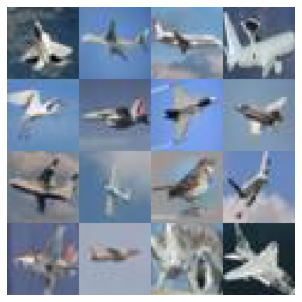

In [25]:
top16 = training_embeds.find(query_doc, limit=16)
top16.plot_image_sprites()

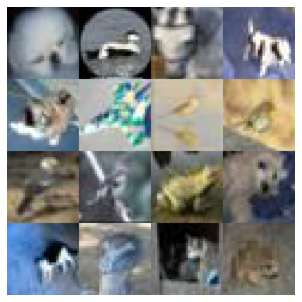

In [26]:
aug_query = c.encode(["rotated_airplane_test.jpg"])
aug_doc = Document(embedding=aug_query)
top16 = training_embeds.find(aug_doc, limit=16)
top16.plot_image_sprites()